## 一、算法介绍

XGBoost（eXtreme Gradient Boosting）是一种高效的梯度提升框架，它实现了梯度提升决策树（Gradient Boosting Decision Trees, GBDT），并在此基础上进行了优化。XGBoost在许多机器学习竞赛中表现出色，因其高效性和强大的预测能力而受到广泛欢迎。XGBoost支持多种目标函数和评估指标，可以处理回归、分类以及排名等问题。

## 二、算法原理

### 2.1 基本概念
XGBoost通过迭代地添加弱学习器来构建一个强学习器。每个新的模型都试图纠正前序模型的残差。与传统的GBDT相比，XGBoost引入了正则化项以防止过拟合，并且使用二阶导数信息来更精确地逼近损失函数。

### 2.2 损失函数
对于回归问题，常用的损失函数$L(y, \hat{y})$可以是均方误差（Mean Squared Error, MSE），即
$$L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2$$

### 2.3 目标函数
XGBoost的目标函数包括损失函数和正则化项：
$$\mathcal{L}(\phi) = \sum_{i=1}^{n} L(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)$$
其中$\Omega(f_k)$是正则化项，通常为
$$\Omega(f_k) = \gamma T + \frac{1}{2}\lambda ||w||^2$$
这里$T$是叶子节点的数量，$w$是叶子节点的权重向量，$\gamma$和$\lambda$是正则化参数。

### 2.4 迭代过程
给定初始模型$\hat{y}_0(x)$，通常是所有样本输出的平均值。之后，在第$t$轮迭代时，我们计算负梯度方向的伪残差$r_{it} = -\left[\frac{\partial L(y_i, \hat{y}_{t-1}(x_i))}{\partial \hat{y}_{t-1}(x_i)}\right]$，并用这些伪残差去训练一个新的回归树$f_t(x; \theta_t)$。更新后的模型为：
$$\hat{y}_t(x) = \hat{y}_{t-1}(x) + f_t(x; \theta_t)$$

## 三、案例分析

本次案例分析使用的数据集包含了一系列工业机器的运行状态记录，包括机器编号、质量等级、工厂温度、机器温度、转速、扭矩、使用时长等特征，以及是否发生故障的标签。我们的任务是基于这些特征预测机器是否会故障。

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1753
           1       0.89      0.51      0.65        47

    accuracy                           0.99      1800
   macro avg       0.94      0.75      0.82      1800
weighted avg       0.98      0.99      0.98      1800



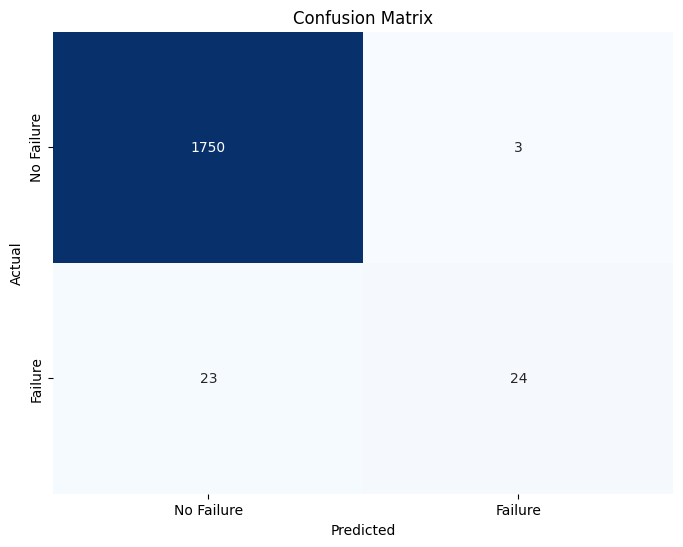

In [2]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_excel('data.xlsx', sheet_name='Sheet1')

# 数据清洗
data.drop_duplicates(inplace=True)
X = data.drop(columns=['机器编号', '是否发生故障', '具体故障类别'])
y = data['是否发生故障']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练模型
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# 预测
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 评估模型
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


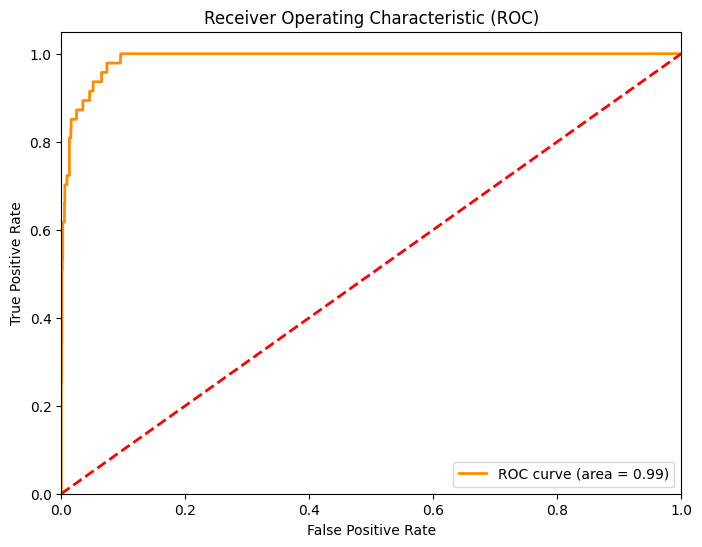

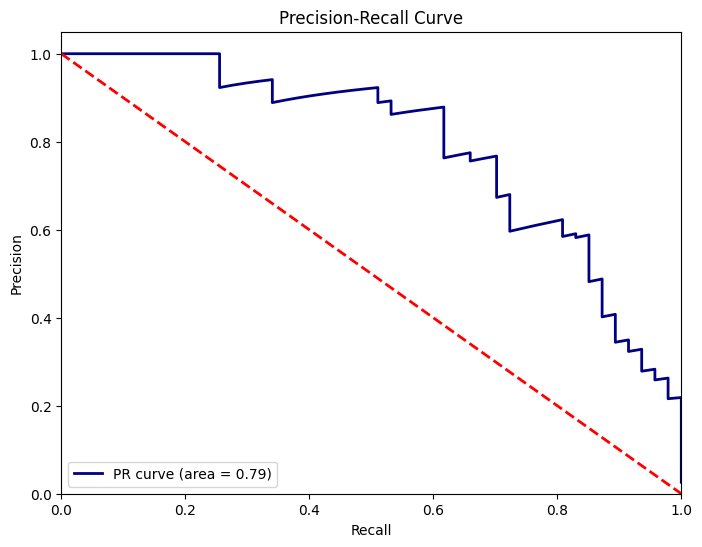

In [3]:
# 计算ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 计算PR曲线
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='navy', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.plot([0, 1], [1, 0], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()